In [1]:
# Import packages
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%run C:/Users/siebe/Documents/JT_Charts.ipynb

ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

In [2]:
# Corpus
## Chinese newspapers
china_daily=pd.read_csv('China Daily.csv')
people_daily=pd.read_csv('People\'s Daily.csv')
xinhua_agent=pd.read_csv('Xinhua Agent.csv')

CH=pd.concat([china_daily, people_daily, xinhua_agent],axis=0,ignore_index=True)

CH = CH.drop(['title'], axis=1)
CH = CH.dropna(how='all')
CH['newspaper'] = 'CH'

## US newspapers
Wall_Street_Journal = pd.read_csv('Wall Street Journal.csv')
Washington_post = pd.read_csv('Washington Post.csv')
New_York_Times = pd.read_csv('New York Times.csv')

US=pd.concat([Wall_Street_Journal, New_York_Times, Washington_post],axis=0,ignore_index=True)

US = US.drop(['title'], axis=1)
US = US.dropna(how='all')
US['newspaper'] = 'US'

corpus = pd.concat([US, CH],axis=0,ignore_index=True)
corpus.head()

,text,newspaper
0,[Financial Analysis and Commentary]\nPolitical...,US
1,China appears to be making its long-expected m...,US
2,[Financial Analysis and Commentary]\nIn his pu...,US
3,The possibility that Beijing would call in its...,US
4,Hong Kong -- President Xi Jinping wanted Tuesd...,US


In [3]:
# Balance
corpus['newspaper'].value_counts()

US    552
CH    549
Name: newspaper, dtype: int64

In [4]:
keywords = ["\'s", "china daily", "people daily", "xinhua", 
            "wall street journal", "new york times", "washington post",
            "nyt", "washington",
            "editorial", "commentary", "crdito", "keith"]

# Case removal, non-alpha removal, keyword removal, and stemming
corpus['text'] = corpus['text'].str.split()
corpus['text'] = corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', "",y.lower()) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [y for y in x if y not in keywords])
corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(y) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x)])
corpus['text'] = pd.Series(corpus['text']).astype(str)
corpus.head()

,text,newspaper
0,['financi analysi and polit unrest ha cast dou...,US
1,['china appear to be make it longexpect move t...,US
2,['financi analysi and in hi pursuit of the roa...,US
3,['the possibl that beij would call in it armi ...,US
4,['hong kong presid xi jinp want tuesday beij...,US


In [5]:
# Split data

# Separate features and target
corpus_text = corpus.iloc[:,0]
corpus_classes = corpus.iloc[:,1]

# split the dataset into training and validation datasets 
x_train, x_test, y_train, y_test = train_test_split(corpus_text, corpus_classes, 
                                                    test_size=0.3, stratify=corpus_classes)
print(x_train.head())

252    ['shenzhen china  the shenzhen bay sport cente...
670    ['vicepremi han zheng on wednesday said that e...
954    ['hong kong oct   hong kong high court on frid...
567    [' gather in rain to appeal for peac order in ...
213    ['hong kong  author here are plan to invok a b...
Name: text, dtype: object


In [6]:
# label encode the target variable 
labels = preprocessing.LabelEncoder()
y_train = labels.fit_transform(y_train)
y_test = labels.fit_transform(y_test)
labels.classes_

# Create document term matrices
### Create binary DTM in which words present in doc receive value of one
### Create term frequency DTM to emphasize most commonly used words
### Create TF-IDF DTM to emphasize words most specific to each document

In [7]:
# Create Unigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1), binary=True) 
vectorizer.fit(x_train)
binary1_train = vectorizer.transform(x_train)
binary1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary1_train.toarray()) 

Count of terms 4735
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
# Create Bigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2), binary=True) 
vectorizer.fit(x_train)
binary2_train = vectorizer.transform(x_train)
binary2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary2_train.toarray()) 

Count of terms 10691
[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
# Create Trigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3), binary=True) 
vectorizer.fit(x_train)
binary3_train = vectorizer.transform(x_train)
binary3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary3_train.toarray()) 

Count of terms 12671
[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# Create Unigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1)) 
vectorizer.fit(x_train)
tf1_train = vectorizer.transform(x_train)
tf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf1_train.toarray()) 

Count of terms 4735
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
# Create Bigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2)) 
vectorizer.fit(x_train)
tf2_train = vectorizer.transform(x_train)
tf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf2_train.toarray()) 

Count of terms 10691
[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
# Create Trigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3)) 
vectorizer.fit(x_train)
tf3_train = vectorizer.transform(x_train)
tf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf3_train.toarray()) 

Count of terms 12671
[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Create Unigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1))
vectorizer.fit(x_train)
tfidf1_train = vectorizer.transform(x_train)
tfidf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf1_train.toarray()) 

Count of terms 4735
[[0.         0.         0.         ... 0.         0.04013679 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
# Create Bigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2))
vectorizer.fit(x_train)
tfidf2_train = vectorizer.transform(x_train)
tfidf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf2_train.toarray()) 

Count of terms 10691
[[0.         0.         0.         ... 0.03463022 0.03463022 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [15]:
# Create Trigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3))
vectorizer.fit(x_train)
tfidf3_train = vectorizer.transform(x_train)
tfidf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf3_train.toarray())

Count of terms 12671
[[0.         0.         0.         ... 0.03341607 0.03341607 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Model nine configurations in a loop

In [16]:
# Define model training
def train_model(dtm, test):
    # model the training data
    clf.fit(dtm, y_train)
    
    # predictions on the test data
    preds = clf.predict(test)
    
    # print metrics
    print("Accuracy:", '{:1.4f}'.format(accuracy_score(y_test, preds)))
    print("F1 Score:", '{:1.4f}'.format(f1_score(y_test, preds)))
    print("")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    return '{:1.4f}'.format(accuracy_score(y_test, preds))

In [17]:
from sklearn.linear_model import LogisticRegression

# Use Naive Bayes
clf = XGBClassifier() #MultinomialNB()

# Model Configurations
binary1 = ("unigram, binary", binary1_train, binary1_test)
binary2 = ("bigram, binary",  binary2_train, binary2_test)
binary3 = ("trigram, binary", binary3_train, binary3_test)
tf1 = ("unigram, TF", tf1_train, tf1_test)
tf2 = ("bigram, TF",  tf2_train, tf2_test)
tf3 = ("trigram, TF", tf3_train, tf3_test)
tfidf1 = ("unigram, TF-IDF", tfidf1_train, tfidf1_test)
tfidf2 = ("bigram, TF-IDF",  tfidf2_train, tfidf2_test)
tfidf3 = ("trigram, TF-IDF", tfidf3_train, tfidf3_test)
DTMs = [binary1, binary2, binary3,
        tf1, tf2, tf3,
        tfidf1, tfidf2, tfidf3]

df = pd.DataFrame({"config": [],
                   "accuracy": []})
best_config = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(data[1], data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config[2]):
        best_config = ["Best Configuration:", data[0], score, data[1], data[2]]
    df = df.append({"config": data[0],
               "accuracy": float(score)},
               ignore_index=True)
    

unigram, binary

Accuracy: 0.9728
F1 Score: 0.9728

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       165
           1       0.98      0.97      0.97       166

    accuracy                           0.97       331
   macro avg       0.97      0.97      0.97       331
weighted avg       0.97      0.97      0.97       331

Confusion Matrix:
[[161   4]
 [  5 161]]

bigram, binary

Accuracy: 0.9637
F1 Score: 0.9643

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       165
           1       0.95      0.98      0.96       166

    accuracy                           0.96       331
   macro avg       0.96      0.96      0.96       331
weighted avg       0.96      0.96      0.96       331

Confusion Matrix:
[[157   8]
 [  4 162]]

trigram, binary

Accuracy: 0.9698
F1 Score: 0.9704

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       16

In [18]:
# Each model's result
df

,config,accuracy
0,"unigram, binary",0.9728
1,"bigram, binary",0.9637
2,"trigram, binary",0.9698
3,"unigram, TF",0.9517
4,"bigram, TF",0.9668
5,"trigram, TF",0.9637
6,"unigram, TF-IDF",0.9637
7,"bigram, TF-IDF",0.9607
8,"trigram, TF-IDF",0.9668


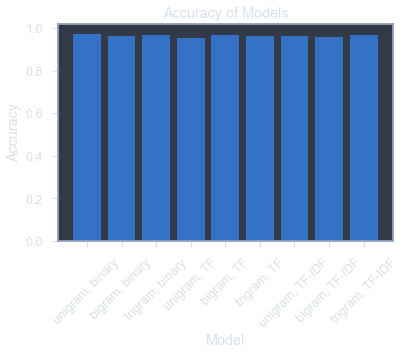

In [25]:
# Create plot
plt.figure()

# Create plot title
plt.title("Accuracy of Models")

# Add bars
plt.bar(range(df.shape[0]), df['accuracy'])
plt.yticks([0,.2,.4,.6,.8,1])
plt.ylabel('Accuracy')

# Add feature names as x-axis labels
plt.xticks(range(df.shape[0]), df['config'], rotation=45)
plt.xlabel('Model')

# Show plot
plt.show()

In [20]:
# Best Configuration
print(best_config)

['Best Configuration:', 'unigram, binary', '0.9728', <770x4735 sparse matrix of type '<class 'numpy.int64'>'
	with 173568 stored elements in Compressed Sparse Row format>, <331x4735 sparse matrix of type '<class 'numpy.int64'>'
	with 76576 stored elements in Compressed Sparse Row format>]


In [21]:
# Best Configuration
clf.fit(best_config[3], y_train)

# predictions on the test data
preds = clf.predict(best_config[4])

# feature importance
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [vectorizer.get_feature_names()[i] for i in indices]

In [22]:
# Main features
names[0:50]

['crdito keith',
 'depart',
 'govern reiter',
 'everi hong',
 'hardcor',
 'elsewher',
 'affect busi',
 'help boost',
 'harden',
 'historian',
 'hksar said',
 'haul',
 'ha alway',
 'basic law said',
 'accus polic',
 'framework',
 'angel',
 'caus troubl',
 'enlist',
 'form human chain',
 'better',
 'administr ha',
 'comment hong kong',
 'day wa',
 'faction',
 'audienc',
 'align',
 'china',
 'detaine',
 'form intern affair',
 'better progress hong',
 'effort end',
 'franci',
 'consider',
 'alleg',
 'anoth',
 'basic law hksar',
 'correspond action',
 'extrem violent',
 'attack liaison',
 'china ha becom',
 'addit',
 'countri ha',
 'big',
 'feder women',
 'group hold',
 'beij issu',
 'avoid',
 'float',
 'affair pure']

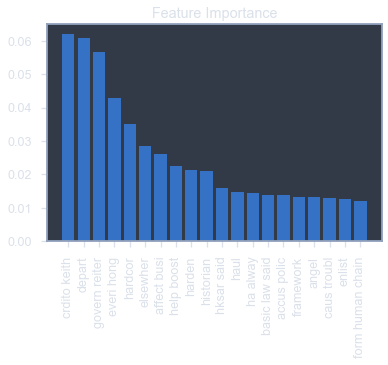

In [23]:
num_features = 20

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(num_features), importances[indices][0:num_features])

# Add feature names as x-axis labels
plt.xticks(range(num_features), names[0:num_features], rotation=90)

# Show plot
plt.show()